# Pandas - spojování tabulek a vztahy mezi více proměnnými

Tato lekce se nese ve znamení mnohosti a propojování - naučíš se:

- pracovat s více tabulkami najednou
- nacházet spojitosti mezi dvěma (a více) proměnnými

Při tom společně projdeme (ne poprvé a ne naposledy) čištění reálných datových sad.

In [1]:
# Importy jako obvykle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Spojování tabulek

V lekci, kde jsme zpracovávali data o počasí, jsme ti ukázali, že je pomocí funkce `concat` možné slepit dohromady několik objektů `DataFrame` či `Series`, pokud mají "kompatibilní" index. Nyní se na problematiku podíváme trochu blíže a ukážeme si, jak spojovat tabulky na základě různých sloupců, a co dělat, když řádky z tabulky jedné nepasují přesně na tabulku druhou.

Obecně pro spojování `pandas` nabízí čtyři funkce / metody, z nichž každá má svoje typické využití:

- [`concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) je univerzální funkce pro slepování dvou či více tabulek / sloupců - pod sebe, vedle sebe, s přihlédnutím k indexům i bez něj. 
- [`append`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html) (metoda) zjednodušuje práci s `concat`, pokud jen chceš do nějaké tabulky přidat pár řádků.
- [`merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html) je univerzální funkce pro spojování tabulek na základě vazby mezi indexy nebo sloupci.
- [`join`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) (metoda) zjednodušuje práci, když chceš spojit dvě tabulky na základě indexu.

Detailní rozbor toho, co která umí, najdeš v [dokumentaci](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html). Mnoho věcí lze udělat použitím dvou (nebo i tří) z výše
uvedených možností.

### Jednoduché skládání

#### Pod sebou

To je asi ten nejjednodušší případ - máme dva objekty `Series` nebo dva kusy tabulky se stejnými sloupci a chceme je spojit pod sebou. Protože použití [`append`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html) a [`concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) jsou velice podobná, ukážeme si je bez většího halasu hned obě najednou:

In [2]:
a = pd.Series([1, 2, 3])
b = pd.Series([4, 5, 6])

In [3]:
a.append(b)

0    1
1    2
2    3
0    4
1    5
2    6
dtype: int64

💡 Vidíš, že se index opakuje? Vytvořili jsme dvě `Series`, u kterých jsme index neřešili. Jenže `pandas` na rozdíl od nás ano, a tak poslušně oba indexy spojil, i za cenu duplicitních hodnot. Za cenu použití dodatečného argumentu `ignore_index=True` se tomu lze vyhnout, což si ukážeme na příklady spojování dvou tabulek o stejných sloupcích:

In [4]:
df1 = pd.DataFrame({
    "levy": [1, 2],
    "pravy": [3, 4]
})
df2 = pd.DataFrame({
    "levy": [25, 26],
    "pravy": [47, 48]
})
df1.append(df2, ignore_index=True)

,levy,pravy
0,1,3
1,2,4
2,25,47
3,26,48


Totéž s použitím `concat`:

In [5]:
pd.concat([a, b])

0    1
1    2
2    3
0    4
1    5
2    6
dtype: int64

In [6]:
pd.concat(1000 * [a], ignore_index=True)

0       1
1       2
2       3
3       1
4       2
       ..
2995    2
2996    3
2997    1
2998    2
2999    3
Length: 3000, dtype: int64

#### Vedle sebe

Když chceme "lepit" doprava (třeba deset `Series`), stačí přidat nám dobře známý argument `axis`:

In [7]:
pd.concat([a] * 10, axis="columns")

,0,1,2,3,4,5,6,7,8,9
0,1,1,1,1,1,1,1,1,1,1
1,2,2,2,2,2,2,2,2,2,2
2,3,3,3,3,3,3,3,3,3,3


**Příklad:** Jak co nejrychleji "nakreslit prázdnou šachovnici" (obě slova jsou v uvozovkách) z číslic 0 a 1?

In [8]:
sachy = pd.concat(
    [
        pd.concat(   
            [pd.DataFrame([[0, 1], [1, 0]])] * 4,
            axis=1)
    ] * 4
)
sachy.index = list(range(1, 9))
sachy.columns = list("ABCDEFGH")
sachy

,A,B,C,D,E,F,G,H
1,0,1,0,1,0,1,0,1
2,1,0,1,0,1,0,1,0
3,0,1,0,1,0,1,0,1
4,1,0,1,0,1,0,1,0
5,0,1,0,1,0,1,0,1
6,1,0,1,0,1,0,1,0
7,0,1,0,1,0,1,0,1
8,1,0,1,0,1,0,1,0


### Spojování různorodých tabulek

🎦 Pro spojování heterogenních dat (v datové hantýrce "joinování") sáhneme po trochu komplexnějších filmových datech...

Data jsou docela veliká. Jsou tak veliká, že ti je nemůžeme naservírovat na stříbrném podnose (leda bys sebou takový podnos měl/a a na něm ležela flashka - na tu ti je můžeme nahrát). Nabízí se dvě možnosti, jak je můžeš získat:

**Alternativa 1.** Stáhni si manuálně do aktuálního adresáře následující soubory:

- https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/title.basics.tsv.gz
- https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/title.ratings.tsv.gz
- https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/rotten_tomatoes_top_movies_2019-01-15.csv
- https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/boxoffice_march_2019.csv.gz

**Alternativa 2:** Pusť si (ideálně ještě doma, před hodinou) následující kód, který stáhne všechny potřebné soubory. Navíc to učiní pouze jednou, opětovné volání už nic dalšího nestahuje.

<div style="color: red; background: yellow">Vyřešit, odkud budeme data brát, jsou to stovky MB a navíc není jasné, jak moc legální je mít je lokálně uložená.</div>

In [9]:
# Nutné importy ze standardní knihovny
import os
from urllib.request import urlretrieve

# Seznam souborů (viz níže)
zdroje = [
    "https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/title.basics.tsv.gz",
    "https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/title.ratings.tsv.gz",
    "https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/rotten_tomatoes_top_movies_2019-01-15.csv",
    "https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/boxoffice_march_2019.csv.gz"
]

for url in zdroje:
    # Pouze poslední část cesty adresy datového zdroje je jeho jméno
    jmeno = url.rsplit("/")[-1]
    
    if not os.path.exists(jmeno):        
        print(f"Soubor {jmeno} ještě není stažen, jdeme na to...")
        urlretrieve(url=url, filename=jmeno)
        print(f"Soubor {jmeno} úspěšně stažen.")
    else:
        print(f"Soubor {jmeno} už byl stažen, použijeme místní kopii.")
print("Všechny soubory jsou staženy.")

Soubor title.basics.tsv.gz už byl stažen, použijeme místní kopii.
Soubor title.ratings.tsv.gz už byl stažen, použijeme místní kopii.
Soubor rotten_tomatoes_top_movies_2019-01-15.csv už byl stažen, použijeme místní kopii.
Soubor boxoffice_march_2019.csv.gz už byl stažen, použijeme místní kopii.
Všechny soubory jsou staženy.


**Hotovo? :-)**

Máme staženo několik souborů, načteme si je (zatím hrubě, "raw") - s přihlédnutím k tomu, že první dva nejsou v pravém slova smyslu "comma-separated", ale používají k oddělení hodnot tabulátor (tady pomůže argument `sep`). Také zohledníme, že v nich řetězec `"\N"` představuje chybějící hodnoty (pomůže argument `na_values`):

In [10]:
imdb_titles_raw = pd.read_csv('title.basics.tsv.gz', sep='\t', na_values="\\N")
imdb_ratings_raw = pd.read_csv('title.ratings.tsv.gz', sep='\t', na_values="\\N")
boxoffice_raw = pd.read_csv('boxoffice_march_2019.csv.gz')
rotten_tomatoes_raw = pd.read_csv("rotten_tomatoes_top_movies_2019-01-15.csv")

Co který soubor obsahuje? 

- První dva soubory obsahují volně dostupná (byť "jen" pro nekomerční použití) data o filmech z IMDB (Internet Movie Database). My jsme si zvolili obecné informace a uživatelská (číselná) hodnocení. Detailní popis souborů, stejně jako odkazy na další soubory, najdeš na https://www.imdb.com/interfaces/. Z důvodů paměťové náročnosti jsme datovou sadu ořezali o epizody seriálů, protože nás nebudou zajímat a s trochu štěstí přežijeme i na počítačích s menší pamětí RAM.

- DOPLNIT 

- DOPLNIT https://www.rottentomatoes.com/

Pojďme se podívat na nedostatky těchto souborů a postupně je skládat dohromady. Zajímalo by nás (a snad i tebe!), jak souvisí hodnocení s komerční úspěšností filmu, jak se liší hodnocení rotten tomatoes od těch na IMDB.

In [11]:
imdb_titles_raw

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,NaN,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
1783511,tt9916734,video,Manca: Peleo,Manca: Peleo,0,2018.0,NaN,NaN,"Music,Short"
1783512,tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,0,2013.0,NaN,NaN,Documentary
1783513,tt9916756,short,Pretty Pretty Black Girl,Pretty Pretty Black Girl,0,2019.0,NaN,NaN,Short
1783514,tt9916764,short,38,38,0,2018.0,NaN,NaN,Short


In [12]:
# Kolik tabulka zabírá paměti?
imdb_titles_raw.memory_usage(deep=True).sum()

680424964

Jistě budeme chtít převést sloupce na správné typy. Jaké jsou v základu?

In [13]:
imdb_titles_raw.dtypes

tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult             int64
startYear         float64
endYear           float64
runtimeMinutes    float64
genres             object
dtype: object

Na co budeme převádět?

- `tconst` je řetězec, který posléze použijeme jako index, protože představuje unikátní identifikátor v databázi IMDB.
- `titleType`:

In [14]:
imdb_titles_raw["titleType"].value_counts()

short           676930
movie           514654
video           227582
tvSeries        162781
tvMovie         126507
tvMiniSeries     25574
videoGame        23310
tvSpecial        17007
tvShort           9171
Name: titleType, dtype: int64

Jen devět různých hodnot ve skoro 2 milionech řádků? To je ideální kandidát na převedení na typ `"category"`.

- `primaryTitle` a `originalTitle` vypadají jako obyčejné řetězce (pokud možno anglický a pokud možno původní název)
- `isAdult` určuje, zda se jedná o dílo pro dospělé. Tento sloupec bychom nejspíše měli převést na `bool`.

In [15]:
imdb_titles_raw["isAdult"].value_counts()

0    1692292
1      91224
Name: isAdult, dtype: int64

- `startYear` a `endYear` obsahují roky, t.j. celá čísla, ovšem kvůli chybějícím hodnotám je pro ně zvolen typ `float64`. V `pandas` raději zvolíme tzv. "nullable integer", který se zapisuje s velkým "I". V našem případě (hodnoty menší než 32767) si vystačíme s `Int16`.
- skoro totéž platí pro `runtimeMinutes`. Ovšem opravdu není žádná délka větší než 32767?

In [16]:
# Jsou všechny hodnoty menší než 32767?
imdb_titles_raw[["startYear", "endYear", "runtimeMinutes"]].max()

startYear           2115.0
endYear             2027.0
runtimeMinutes    125156.0
dtype: float64

Mimochodem všimli jste si, že máme díla z budoucnosti (rok 2115)?

2020.0    340
2021.0     36
2022.0     14
2023.0      1
2024.0      2
2025.0      1
2115.0      1
Name: startYear, dtype: int64

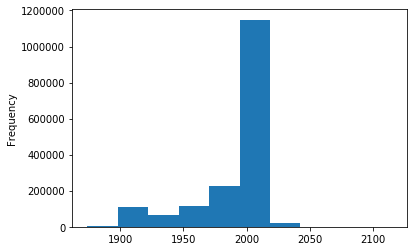

In [17]:
imdb_titles_raw["startYear"].plot.hist()
imdb_titles_raw.query("startYear > 2019")["startYear"].value_counts().sort_index()

Takhle nějak by přetypování mohlo vypadat:

In [18]:
(
    imdb_titles_raw
    .assign(
        titleType=imdb_titles_raw["titleType"].astype("category"),
        startYear=imdb_titles_raw["startYear"].astype("Int16"),
        endYear=imdb_titles_raw["endYear"].astype("Int16"),
        isAdult=imdb_titles_raw["isAdult"].astype(bool),
        runtimeMinutes=imdb_titles_raw["runtimeMinutes"].astype("Int32")
    )
).dtypes

tconst              object
titleType         category
primaryTitle        object
originalTitle       object
isAdult               bool
startYear            Int16
endYear              Int16
runtimeMinutes       Int32
genres              object
dtype: object

Takhle už by to mohlo být. Jen si ještě:

- pro přehlednost přejmenujeme některé sloupce
- použijeme `tconst` jako index

A tabulka `imdb_titles` bude připravená k použití!

In [19]:
imdb_titles = (
    imdb_titles_raw
    .assign(
        titleType=imdb_titles_raw["titleType"].astype("category"),
        startYear=imdb_titles_raw["startYear"].astype("Int32"),
        endYear=imdb_titles_raw["endYear"].astype("Int32"),
        isAdult=imdb_titles_raw["isAdult"].astype(bool),
        runtimeMinutes=imdb_titles_raw["runtimeMinutes"].astype("Int32")
    )
    .rename({
        "primaryTitle": "title",
        "originalTitle": "original_title",
        "titleType": "title_type",
        "runtimeMinutes": "length",
        "startYear": "start_year",
        "endYear": "end_year",
        "isAdult": "is_adult",
    }, axis="columns")
    .set_index("tconst")
)
imdb_titles

,title_type,title,original_title,is_adult,start_year,end_year,length,genres
tconst,,,,,,,,
tt0000001,short,Carmencita,Carmencita,False,1894,NaN,1,"Documentary,Short"
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,False,1892,NaN,5,"Animation,Short"
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,False,1892,NaN,4,"Animation,Comedy,Romance"
tt0000004,short,Un bon bock,Un bon bock,False,1892,NaN,NaN,"Animation,Short"
tt0000005,short,Blacksmith Scene,Blacksmith Scene,False,1893,NaN,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...
tt9916734,video,Manca: Peleo,Manca: Peleo,False,2018,NaN,NaN,"Music,Short"
tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,False,2013,NaN,NaN,Documentary
tt9916756,short,Pretty Pretty Black Girl,Pretty Pretty Black Girl,False,2019,NaN,NaN,Short


In [20]:
# Kolik tabulka zabírá paměti?
imdb_titles.memory_usage(deep=True).sum()   # O chlup méně, zase tolik jsme si nepomohli.

541995019

Připravíme si ještě speciální tabulku jenom pro filmy, protože další datové sady se zabývají jenom jimi.

U této tabulky navíc vyhodíme `title_type`, `end_year` a přejmenujeme `start_year` prostě na `year`:

In [21]:
movies = (
    imdb_titles
    .query("title_type == 'movie'")
    .drop(["title_type", "end_year"], axis="columns")
    .rename({"start_year": "year"}, axis="columns")
)
movies

,title,original_title,is_adult,year,length,genres
tconst,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport"
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,NaN,"Biography,Drama"
tt0000502,Bohemios,Bohemios,False,1905,100,NaN
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama"
...,...,...,...,...,...,...
tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,False,2015,NaN,Documentary
tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,False,2007,100,Documentary
tt9916706,Dankyavar Danka,Dankyavar Danka,False,2013,NaN,Comedy


In [22]:
print(movies.shape)
print(movies.dtypes)

(514654, 6)
title             object
original_title    object
is_adult            bool
year               Int32
length             Int32
genres            object
dtype: object


Nyní se podíváme na zoubek hodnocením z IMDB, na tabulky `imdb_ratings_raw`:

In [23]:
imdb_ratings_raw

,tconst,averageRating,numVotes
0,tt0000001,5.8,1486
1,tt0000002,6.4,179
2,tt0000003,6.6,1117
3,tt0000004,6.4,109
4,tt0000005,6.2,1820
...,...,...,...
923691,tt9916380,9.7,58
923692,tt9916420,7.0,5
923693,tt9916460,9.2,12
923694,tt9916720,5.2,11


In [24]:
imdb_ratings_raw.dtypes

tconst            object
averageRating    float64
numVotes           int64
dtype: object

To by vlastně skoro mohlo být!

Tak jen nastavíme index (opět `tconst`) a přejmenujeme sloupce:

In [25]:
ratings = (imdb_ratings_raw
    .rename({
        "averageRating": "imdb_rating",
        "numVotes": "imdb_votes"
    }, axis="columns")
    .set_index("tconst")
)
ratings

,imdb_rating,imdb_votes
tconst,,
tt0000001,5.8,1486
tt0000002,6.4,179
tt0000003,6.6,1117
tt0000004,6.4,109
tt0000005,6.2,1820
...,...,...
tt9916380,9.7,58
tt9916420,7.0,5
tt9916460,9.2,12


#### Join č. 1

Máme připravené dvě krásné tabulky, které sdílejí stejný index, a můžeme vesele spojovat. Protože pomocí `join`, `merge` a `concat` lze volbou vhodných parametrů dosáhnout identického výsledku (což je jedním z nešvarů knihovny `pandas`), ukážeme si všechny tři alternativy podle subjektivního pořadí vhodnosti. A úplně nakonec si ukážeme, jak by to šlo, ale rozhodně by se dělat nemělo!

In [26]:
movies.join(ratings)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tconst,,,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.5,77.0
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport",5.2,289.0
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,NaN,"Biography,Drama",6.3,39.0
tt0000502,Bohemios,Bohemios,False,1905,100,NaN,NaN,NaN
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama",6.2,505.0
...,...,...,...,...,...,...,...,...
tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,False,2015,NaN,Documentary,NaN,NaN
tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,False,2007,100,Documentary,NaN,NaN
tt9916706,Dankyavar Danka,Dankyavar Danka,False,2013,NaN,Comedy,NaN,NaN


K tabulce se nenápadně přidaly dva sloupce z tabulky `ratings`, a to takovým způsobem, že se porovnaly hodnoty indexu (tedy `tconst`) a spárovaly se ty části řádku, kde se tento index shoduje.

💡 Uvědom si (ačkoliv z volání funkcí v `pandas` to není úplně zřejmé), že se tady děje něco fundamentálně odlišného od "nalepení doprava" - tabulky tu nejsou chápány jako čtverečky, které jde skládat jako lego, nýbrž jako zdroj údajů o jednotlivých objektech, které je potřeba spojit sémanticky.

Jak ale vidíš, tabulka obsahuje spoustu řádků, kde ve sloupcích s hodnocením chybí hodnoty (respektive nachází se `NaN`). To výchází ze způsobu, jakým metoda `join` ve výchozím nastavení "joinuje" - použije všechny řádky z levé tabulky bez ohledu na to, jestli jim odpovídá nějaký protějšek v tabulce pravé. Naštěstí lze pomocí argumentu `how` specifikovat i jiné způsoby spojování:

- `left` (výchozí pro metodu `join`) - vezmou se všechny prvky z levé tabulky a jim odpovídající prvky z pravé tabulky (kde nejsou, doplní se `NaN`)
- `right` - vezmou se všechny prvky z pravé tabulky a jim odpovídající prvky z levé tabulky (kde nejsou, doplní se `NaN`)
- `inner` (výchozí pro funkci `merge`) - vezmou se jen ty prvky, které jsou v levé i pravé tabulce.
- `outer` (výchozí pro funkci `concat`) - vezmou se všechny prvky, z levé i pravé tabulky, kde něco chybí, doplní se `NaN`.

V podobě Vennově diagramu, kde kruhy představují množiny řádků v obou zdrojových tabulkách a modrou barvou jsou zvýrazněny řádky v tabulce cílové:

![Typy joinů](static/joins.svg)

*Obrázek adaptován z https://upload.wikimedia.org/wikipedia/commons/9/9d/SQL_Joins.svg (autor: Arbeck)*

💡 Až budeme probírat databáze, tyto čtyři typu joinů se nám znovu vynoří.

**Otázka:** Následující výpis ukáže, kolik řádků bychom dostali při použití různých hodnot `how`. Odhadneš, která hodnota je ideální pro náš případ?

In [27]:
for how in ["left", "right", "inner", "outer"]:
    print(f"movies.join(ratings, how=\"{how}\"):", movies.join(ratings, how=how).shape[0], "řádků.")

movies.join(ratings, how="left"): 514654 řádků.
movies.join(ratings, how="right"): 923696 řádků.
movies.join(ratings, how="inner"): 232496 řádků.
movies.join(ratings, how="outer"): 1205854 řádků.


A teď tedy ty čtyři alternativy:

In [28]:
# Alternativa 1 (preferovaná)
movies_with_rating = movies.join(ratings, how="inner")
movies_with_rating

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tconst,,,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.5,77
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport",5.2,289
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,NaN,"Biography,Drama",6.3,39
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama",6.2,505
tt0000615,Robbery Under Arms,Robbery Under Arms,False,1907,NaN,Drama,4.8,14
...,...,...,...,...,...,...,...,...
tt9910930,Jeg ser deg,Jeg ser deg,False,2019,75,"Crime,Documentary",4.6,5
tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,False,2019,130,Drama,8.5,363
tt9913056,Swarm Season,Swarm Season,False,2019,86,Documentary,6.2,5


In [29]:
# Alternativa 2 (taky dobrá)
pd.merge(movies, ratings, left_index=True, right_index=True)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tconst,,,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.5,77
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport",5.2,289
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,NaN,"Biography,Drama",6.3,39
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama",6.2,505
tt0000615,Robbery Under Arms,Robbery Under Arms,False,1907,NaN,Drama,4.8,14
...,...,...,...,...,...,...,...,...
tt9910930,Jeg ser deg,Jeg ser deg,False,2019,75,"Crime,Documentary",4.6,5
tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,False,2019,130,Drama,8.5,363
tt9913056,Swarm Season,Swarm Season,False,2019,86,Documentary,6.2,5


In [30]:
# Alternativa 3 (méně "sémantická")
pd.concat([movies, ratings], axis="columns", join="inner")

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tconst,,,,,,,,
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.5,77
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport",5.2,289
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,NaN,"Biography,Drama",6.3,39
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama",6.2,505
tt0000615,Robbery Under Arms,Robbery Under Arms,False,1907,NaN,Drama,4.8,14
...,...,...,...,...,...,...,...,...
tt9910930,Jeg ser deg,Jeg ser deg,False,2019,75,"Crime,Documentary",4.6,5
tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,False,2019,130,Drama,8.5,363
tt9913056,Swarm Season,Swarm Season,False,2019,86,Documentary,6.2,5


In [31]:
# Alternativa 4 (ok, tahle JE špatná)!
# Omezíme se na začátek tabulky, nebo nám dojde paměť

# `append` vkládá jen pod sebe, tak si tabulky otočíme!
df1 = movies[:6].T   
df2 = ratings.T
(
    df1
    .append(df2, sort=False)  # Sloučíme "řádky"
    .T                           # Otočíme zpátky
    .dropna(                     # Vyhodíme nepasující (emulace "inner")
        subset=["title", "imdb_rating"],
        
    )
)

# Začátek tabulky sedí!

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
tt0000009,Miss Jerry,Miss Jerry,False,1894,45,Romance,5.5,77
tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,20,"Documentary,News,Sport",5.2,289
tt0000335,Soldiers of the Cross,Soldiers of the Cross,False,1900,NaN,"Biography,Drama",6.3,39
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70,"Biography,Crime,Drama",6.2,505
tt0000615,Robbery Under Arms,Robbery Under Arms,False,1907,NaN,Drama,4.8,14


Zkusme si zreprodukovat pořadí 250 nejlepších filmů z IMDB (viz https://www.imdb.com/chart/top/?ref_=nv_mv_250):

In [32]:
# Ty nejlepší (do června 2019)
(movies_with_rating
    .query("imdb_votes > 25000")                  # Berou se jen filmy s více než 25000 hlasy
    .sort_values("imdb_rating", ascending=False)   # IMDB tu použivá i váhu jednotlivých hlasů (kterou neznáme)
    .reset_index(drop=True)
).iloc[:250]

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
0,The Chaos Class,Hababam Sinifi,False,1975,87,"Comedy,Drama",9.4,33394
1,The Shawshank Redemption,The Shawshank Redemption,False,1994,142,Drama,9.3,2071759
2,The Mountain II,Dag II,False,2016,135,"Action,Drama,War",9.3,100095
3,CM101MMXI Fundamentals,CM101MMXI Fundamentals,False,2013,139,"Comedy,Documentary",9.2,41327
4,The Godfather,The Godfather,False,1972,175,"Crime,Drama",9.2,1421495
...,...,...,...,...,...,...,...,...
245,12 Years a Slave,12 Years a Slave,False,2013,134,"Biography,Drama,History",8.1,571204
246,The Sixth Sense,The Sixth Sense,False,1999,107,"Drama,Mystery,Thriller",8.1,836928
247,The Passion of Joan of Arc,La passion de Jeanne d'Arc,False,1928,110,"Biography,Drama,History",8.1,40107
248,Barfi!,Barfi!,False,2012,151,"Comedy,Drama,Romance",8.1,68274


Do výčtu se nám dostaly filmy, které hranici hlasů nepřekračují o moc. Máme důvodné podezření, že toto kritérium dávno změnili. S požadovanými 250 000 hlasy se už blížíme:

In [33]:
(movies_with_rating
    .query("imdb_votes > 250000")
    .sort_values("imdb_rating", ascending=False)
    .reset_index(drop=True)
).iloc[:250]

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes
0,The Shawshank Redemption,The Shawshank Redemption,False,1994,142,Drama,9.3,2071759
1,The Godfather,The Godfather,False,1972,175,"Crime,Drama",9.2,1421495
2,The Dark Knight,The Dark Knight,False,2008,152,"Action,Crime,Drama",9.0,2037678
3,The Godfather: Part II,The Godfather: Part II,False,1974,202,"Crime,Drama",9.0,986451
4,Pulp Fiction,Pulp Fiction,False,1994,154,"Crime,Drama",8.9,1620135
...,...,...,...,...,...,...,...,...
245,Ocean's Eleven,Ocean's Eleven,False,2001,116,"Crime,Thriller",7.8,470530
246,Lost in Translation,Lost in Translation,False,2003,102,Drama,7.8,371577
247,Donnie Brasco,Donnie Brasco,False,1997,127,"Biography,Crime,Drama",7.8,253811
248,Captain Phillips,Captain Phillips,False,2013,134,"Biography,Drama,Thriller",7.8,384378


#### Join č. 2

Co tabulka s výdělky (`boxoffice_raw`)?

In [34]:
boxoffice_raw

,rank,title,studio,lifetime_gross,year
0,1,Star Wars: The Force Awakens,BV,936662225,2015
1,2,Avatar,Fox,760507625,2009
2,3,Black Panther,BV,700059566,2018
3,4,Avengers: Infinity War,BV,678815482,2018
4,5,Titanic,Par.,659363944,1997
...,...,...,...,...,...
16262,16263,Dog Eat Dog,IFC,80,2009
16263,16264,Paranoid Girls,NaN,78,2015
16264,16265,Confession of a Child of the Century,Cohen,74,2015
16265,16266,Storage 24,Magn.,72,2013


In [35]:
boxoffice_raw.dtypes

rank               int64
title             object
studio            object
lifetime_gross     int64
year               int64
dtype: object

S tím bychom v podstatně mohli být spokojení, jen přejmenujeme `rank`, abychom při joinování věděli, odkud daný sloupec pochází.

In [36]:
boxoffice = (boxoffice_raw
    .rename({
        "rank": "boxoffice_rank"
    }, axis="columns")
)

A zkusíme joinovat. V tomto případě se nemůžeme opřít o index (`boxoffice` pochází z jiného zdroje a o nějakém ID filmu z IMDB nemá ani tuchy), ale explicitně specifikujeme, který sloupec (či sloupce) se musí shodovat - na to slouží argument `on`:

In [37]:
pd.merge(
    movies_with_rating,
    boxoffice,
    suffixes=[" (imdb)", " (boxoffice)"],
    on="title"
).query("title == 'Pinocchio'")  # "Jeden" ukázkový film

,title,original_title,is_adult,year (imdb),length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross,year (boxoffice)
1643,Pinocchio,Pinocchio,False,1940,88,"Animation,Comedy,Family",7.5,114689,885,Dis.,84254167,1940
1644,Pinocchio,Pinocchio,False,1940,88,"Animation,Comedy,Family",7.5,114689,6108,Mira.,3684305,2002
1645,Pinocchio,Turlis Abenteuer,False,1967,75,"Adventure,Family,Fantasy",7.2,19,885,Dis.,84254167,1940
1646,Pinocchio,Turlis Abenteuer,False,1967,75,"Adventure,Family,Fantasy",7.2,19,6108,Mira.,3684305,2002
1647,Pinocchio,Pinocchio,False,1971,79,"Comedy,Fantasy",3.5,123,885,Dis.,84254167,1940
1648,Pinocchio,Pinocchio,False,1971,79,"Comedy,Fantasy",3.5,123,6108,Mira.,3684305,2002
1649,Pinocchio,Pinocchio,False,1911,50,Fantasy,5.9,69,885,Dis.,84254167,1940
1650,Pinocchio,Pinocchio,False,1911,50,Fantasy,5.9,69,6108,Mira.,3684305,2002
1651,Pinocchio,Pinocchio,False,2002,108,"Comedy,Family,Fantasy",4.3,7192,885,Dis.,84254167,1940
1652,Pinocchio,Pinocchio,False,2002,108,"Comedy,Family,Fantasy",4.3,7192,6108,Mira.,3684305,2002


Jejda, to jsme asi nechtěli. Existuje spousta různých Pinocchiů a ke každému z nich se připojili vždy oba snímky tohoto jména z `boxoffice`. Z toho vyplývá poučení, že při joinování je dobré se zamyslet nad jedinečností hodnot ve sloupci, který používáme jako klíč (jméno filmu takové očividně není.

V našem konkrétním případě jsme si problému všimli sami, ale pokud bude duplikátní klíč utopen někde v milionech hodnot, rádi bychom, aby to počítač poznal za nás. K tomu slouží argument `validate` (podle toho, jaký vztah mezi tabulkami očekáš, jsou přípustné hodnoty `"one_to_one"`, `"one_to_many"`, `"many_to_one"` nebo `"many_to_many"`):

In [38]:
pd.merge(
    movies_with_rating,
    boxoffice,
    on="title",
    suffixes=[" (imdb)", " (boxoffice)"],
#    validate="one_to_one"    # Odkomentuj a vyskočí chyba!
)

,title,original_title,is_adult,year (imdb),length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross,year (boxoffice)
0,Oliver Twist,Oliver Twist,False,1912,NaN,Drama,4.7,19,6826,Sony,2080321,2005
1,Oliver Twist,Oliver Twist,False,1912,NaN,Drama,4.4,12,6826,Sony,2080321,2005
2,Oliver Twist,Oliver Twist,False,1916,50,Drama,6.6,16,6826,Sony,2080321,2005
3,Oliver Twist,Oliver Twist,False,1922,98,Drama,6.8,657,6826,Sony,2080321,2005
4,Oliver Twist,Oliver Twist,False,1933,80,Drama,5.0,292,6826,Sony,2080321,2005
...,...,...,...,...,...,...,...,...,...,...,...,...
20562,BTS World Tour: Love Yourself in Seoul,BTS World Tour: Love Yourself in Seoul,False,2019,112,"Documentary,Music",8.5,439,6173,Fathom,3509917,2019
20563,Mojin: The Worm Valley,Yun nan chong gu,False,2018,110,"Action,Fantasy",4.7,120,11240,WGUSA,101516,2019
20564,Extreme Job,Geukhanjikeob,False,2019,111,"Action,Comedy",7.3,905,7212,CJ,1548816,2019
20565,Peppa Celebrates Chinese New Year,xiao zhu pei qi guo da nian,False,2019,81,"Animation,Family",3.4,41,10811,STX,131225,2019


Řešení je jednoduché - budeme joinovat přes dva různé sloupce (argument `on` to unese ;-)). Při té příležitosti navíc zjišťujeme, že nedává smysl spojovat filmy, které rok vůbec uvedený nemají, a proto je vyhodíme:

In [39]:
(
    pd.merge(
        movies_with_rating.dropna(subset=["year"]),  # Vyhoď všechny řádky bez roku
        boxoffice,
        on=["title", "year"],
        validate="many_to_one",      # movies_with_rating pořád nejsou unikátní!
    )
).query("title == 'Playback'")

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross
6926,Playback,Playback,False,2012,98,"Horror,Thriller",4.3,4478,16256,Magn.,264
6927,Playback,Playback,False,2012,113,Drama,4.9,27,16256,Magn.,264
6928,Playback,Dur d'être Dieu,False,2012,66,Documentary,5.2,8,16256,Magn.,264


Pořád nejsou unikátní! Co s tím?

**Hypotéza:** Vstupujeme na nebezpečnou půdu a zkusíme spekulovat, že informace o ziscích budeme mít nejspíš jen o nejpopulárnějších filmech. Možná máme pravdu, možná ne a nejspíš nějakou drobnost zaneseme, ale dobrat se tady skutečné pravdy je "drahé" (a možná i skutečně drahé), z nabízených datových sad to věrohodně možné není.

Proto coby nejlepší přiblížení realitě z každé opakující se dvojice (název, rok) vybereme film s nejvyšším `imdb_votes`. Nejdříve si pomocí `sort_values` srovnáme všechny filmy a pak zavoláme `drop_duplicates(..., keep="first")`, což nám ponechá vždy jen jeden z řady duplikátů:

In [40]:
movies_with_rating_and_boxoffice = (
    pd.merge(
        movies_with_rating
            .dropna(subset=["year"])
            .sort_values("imdb_votes", ascending=False)
            .drop_duplicates(
                subset=["title", "year"],
                keep="first"
            ),
        boxoffice,
        on=["title", "year"],
        validate="one_to_one",
    )
)
movies_with_rating_and_boxoffice

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross
0,The Shawshank Redemption,The Shawshank Redemption,False,1994,142,Drama,9.3,2071759,2792,Col.,28341469
1,The Dark Knight,The Dark Knight,False,2008,152,"Action,Crime,Drama",9.0,2037678,10,WB,535234033
2,Inception,Inception,False,2010,148,"Action,Adventure,Sci-Fi",8.8,1816360,85,WB,292576195
3,Fight Club,Fight Club,False,1999,139,Drama,8.8,1657857,2248,Fox,37030102
4,Pulp Fiction,Pulp Fiction,False,1994,154,"Crime,Drama",8.9,1620135,629,Mira.,107928762
...,...,...,...,...,...,...,...,...,...,...,...
8996,Girlfriends,Girlfriends,False,1996,NaN,NaN,8.6,7,13930,FRun,18000
8997,Sacred,Sacred,False,2017,NaN,"Action,Drama,Romance",8.2,6,13950,Argo.,17740
8998,The Professor: Tai Chi's Journey West,The Professor: Tai Chi's Journey West,False,2016,72,Documentary,7.2,6,15820,FRun,2852
8999,After Love,After Love,False,2017,NaN,"Drama,Romance,Thriller",7.6,5,14299,Distrib.,13693


In [41]:
# To už by šlo!
movies_with_rating_and_boxoffice.query("title == 'Playback'")

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross
5831,Playback,Playback,False,2012,98,"Horror,Thriller",4.3,4478,16256,Magn.,264


**Úkol:** Seřaď filmy podle toho, kolik vydělaly (nabízí se hned dvě možnosti).

**Otázka:** Které filmy nám vypadly a proč?

#### Join č. 3 (volitelné)

In [42]:
rotten_tomatoes_raw

,Rank,Title,RatingTomatometer,No. of Reviews,Genres
0,1,Black Panther (2018),97,444,action|adventure
1,2,Mad Max: Fury Road (2015),97,394,action|adventure
2,3,Wonder Woman (2017),93,410,action|adventure
3,4,Metropolis (1927),99,118,action|adventure
4,5,Coco (2017),97,308,action|adventure
...,...,...,...,...,...
1585,70,Priest (2011),15,97,western
1586,71,American Outlaws (2001),14,103,western
1587,72,September Dawn (2007),15,54,western
1588,73,Jonah Hex (2010),12,147,western


In [43]:
rotten_tomatoes_raw["Title"].value_counts()

Yellow Submarine (1968)                                                      6
Fantasia (1940)                                                              5
101 Dalmatians (1961)                                                        5
Who Framed Roger Rabbit (1988)                                               5
Metropolis (1927)                                                            5
                                                                            ..
Once in a Lifetime: The Extraordinary Story of the New York Cosmos (2006)    1
Jonah Hex (2010)                                                             1
Caesar Must Die (2013)                                                       1
Man of the Year (2006)                                                       1
Confirmation (2016)                                                          1
Name: Title, Length: 947, dtype: int64

A zase duplicity, některé názvy se nám opakují :-(

**Otázka:** Dokážeš zjistit proč? Nápověda: podívej se na nějaký konkrétní film.

Naštěstí už víme, jak na to - použijeme metodu `drop_duplicates`, tentokrát přes sloupec `"Title"`. (Poznámka: druhou možností by bylo sloučit všechny různé žánry daného filmu do jedné buňky).

In [44]:
rotten_tomatoes_nodup = (
    rotten_tomatoes_raw
    .drop_duplicates(
        subset="Title",
        keep="first"                   # Vybereme první výskyt, lze i "last" (anebo False => vyhodit všechny)
    )
    .drop("Genres", axis="columns")    # Informační hodnotu jsme už ztratili
    .drop("Rank", axis="columns")      # Mělo smysl jen v rámci žánru
)
rotten_tomatoes_nodup

,Title,RatingTomatometer,No. of Reviews
0,Black Panther (2018),97,444
1,Mad Max: Fury Road (2015),97,394
2,Wonder Woman (2017),93,410
3,Metropolis (1927),99,118
4,Coco (2017),97,308
...,...,...,...
1585,Priest (2011),15,97
1586,American Outlaws (2001),14,103
1587,September Dawn (2007),15,54
1588,Jonah Hex (2010),12,147


In [45]:
# Ready to merge?
pd.merge(imdb_titles, rotten_tomatoes_nodup, left_on="title", right_on="Title")

,title_type,title,original_title,is_adult,start_year,end_year,length,genres,Title,RatingTomatometer,No. of Reviews


0 řádků!

Dosud jsme manipulovali s řádky a sloupci jako celky, nicméně teď musíme zasahovat přímo do hodnot v buňkách. I to se při slučování dat z různých zdrojů nezřídka stává. Stojíme před úkolem převést řetězce typu "Black Panther (2018)" na dvě hodnoty: název "Black Panther" a rok 2018 (jeden sloupec na dva). 

<p style="background:yellow;color=red">Zkontrolovat, jak moc jsme to probírali.</p>

Naštěstí si ty sloupce umíme jednoduše vyrobit pomocí řetězcové funkce [`.str.slice`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.slice.html), která z každého řetězce vyřízne nějaký jeho podúsek. Budeme věřit, že předposlední čtyři znaky představují rok a zbytek, až na nějaké ty závorky, tvoří skutečný název:

In [46]:
rotten_tomatoes_beta = (rotten_tomatoes_nodup
    .assign(
        title=rotten_tomatoes_nodup["Title"].str.slice(0, -7),             
        year=rotten_tomatoes_nodup["Title"].str.slice(-5, -1).astype(int)
    )
    .rename({
        "RatingTomatometer": "tomatoes_rating",
        "No. of Reviews": "tomatoes_votes",
    }, axis="columns")
    .drop(["Title"], axis="columns")
)
rotten_tomatoes_beta

,tomatoes_rating,tomatoes_votes,title,year
0,97,444,Black Panther,2018
1,97,394,Mad Max: Fury Road,2015
2,93,410,Wonder Woman,2017
3,99,118,Metropolis,1927
4,97,308,Coco,2017
...,...,...,...,...
1585,15,97,Priest,2011
1586,14,103,American Outlaws,2001
1587,15,54,September Dawn,2007
1588,12,147,Jonah Hex,2010


Závorková odysea nekončí, někdo nám proaktivně do závorek nacpal i originální název naanglickojazyčných filmů:

In [47]:
rotten_tomatoes_beta[rotten_tomatoes_beta["title"].str.contains("\\(")]

,tomatoes_rating,tomatoes_votes,title,year
15,100,58,Seven Samurai (Shichinin no Samurai),1956
51,98,46,"Aguirre, the Wrath of God (Aguirre, der Zorn G...",1972
61,97,71,Ghostbusters (1984 Original),1984
69,98,47,A Fistful of Dollars (Per un Pugno di Dollari),1964
99,96,139,Embrace Of The Serpent (El Abrazo De La Serpie...,2016
...,...,...,...,...
1368,97,59,To Be and to Have (Etre et Avoir),2003
1457,43,82,Goal! The Dream Begins (Goal!: The Impossible ...,2005
1502,71,52,Only Human (Seres queridos),2006
1547,83,64,"The Good, the Bad, the Weird (Joheun-nom, Nabb...",2010


V rámci zjednodušení proto ještě odstraníme všechny takové závorky. K tomu pomůže funkce `.str.rsplit`, která rozdělí zprava řetězec na několik částí podle oddělovače - my za ten oddělovač zvolíme levou závorku `"("`, omezíme počet částí na jednu až dvě (`n=1`) a vezmeme jen tu první.

In [48]:
rotten_tomatoes = (rotten_tomatoes_beta
    .assign(
        title=rotten_tomatoes_beta["title"].str.rsplit("(", n=1).apply(lambda x: x[0])
    )
)
rotten_tomatoes

,tomatoes_rating,tomatoes_votes,title,year
0,97,444,Black Panther,2018
1,97,394,Mad Max: Fury Road,2015
2,93,410,Wonder Woman,2017
3,99,118,Metropolis,1927
4,97,308,Coco,2017
...,...,...,...,...
1585,15,97,Priest,2011
1586,14,103,American Outlaws,2001
1587,15,54,September Dawn,2007
1588,12,147,Jonah Hex,2010


In [49]:
# Zbavení se duplikátů hned na začátku nám zachovalo filmy se stejným jménem :-)
rotten_tomatoes.query("title == 'The Magnificent Seven'")

,tomatoes_rating,tomatoes_votes,title,year
1539,88,42,The Magnificent Seven,1960
1560,63,289,The Magnificent Seven,2016


In [50]:
pd.merge(
    movies.dropna(subset=["year"]),
    rotten_tomatoes,
    on=["title", "year"],
    how="inner"
)

,title,original_title,is_adult,year,length,genres,tomatoes_rating,tomatoes_votes
0,The Birth of a Nation,The Birth of a Nation,False,1915,195,"Drama,History,War",98,40
1,Battleship Potemkin,Bronenosets Potemkin,False,1925,75,"Drama,History",100,45
2,The Gold Rush,The Gold Rush,False,1925,95,"Adventure,Comedy,Drama",100,43
3,Metropolis,Metropolis,False,1927,153,"Drama,Sci-Fi",99,118
4,All Quiet on the Western Front,All Quiet on the Western Front,False,1930,136,"Drama,War",100,42
...,...,...,...,...,...,...,...,...
654,Three Identical Strangers,Three Identical Strangers,False,2018,96,"Biography,Documentary,Drama",96,157
655,Searching,Searching,False,2018,102,"Drama,Mystery,Thriller",92,214
656,Won't You Be My Neighbor?,Won't You Be My Neighbor?,False,2018,94,"Biography,Documentary",98,216
657,RBG,RBG,False,2018,98,"Biography,Documentary",95,153


Když sloučíme filmy a hodnocení na Rotten Tomatoes, z 947 filmů se nám skoro tři sta ztratí. Bohužel zde je na vině především nestejnost zápisu názvu, různé uřčité členy, interpunkce, podnázvy apod. Coby řešení se tady nabízí spousta a spousta manuální práce, případně nějaká heuristika, která by na sebe pasovala "hodně podobné" názvy.

*Mimochodem, odpor k manuální práci se mezi vývojáři někdy přeceňuje: Opravit 288 názvů filmů může být práce na hodinu až dvě, zatímco psát algoritmus na "řešení problému" může trvat stejně dlouho, ne-li déle.*

#### Join č. 4 (ultimátní)

Dokončíme slučování všech čtyř tabulek:

In [51]:
movies_complete = pd.merge(
    movies_with_rating_and_boxoffice,
    rotten_tomatoes,
    on=["title", "year"],
    how="inner"
)
movies_complete.sort_values("boxoffice_rank").reset_index(drop=True)

,title,original_title,is_adult,year,length,genres,imdb_rating,imdb_votes,boxoffice_rank,studio,lifetime_gross,tomatoes_rating,tomatoes_votes
0,Black Panther,Black Panther,False,2018,134,"Action,Adventure,Sci-Fi",7.3,489977,3,BV,700059566,97,444
1,Avengers: Infinity War,Avengers: Infinity War,False,2018,149,"Action,Adventure,Sci-Fi",8.5,616050,4,BV,678815482,84,408
2,Titanic,Titanic,False,1997,194,"Drama,Romance",7.8,945889,5,Par.,659363944,89,184
3,Incredibles 2,Incredibles 2,False,2018,118,"Action,Adventure,Animation",7.7,192301,9,BV,608581744,94,332
4,The Dark Knight,The Dark Knight,False,2008,152,"Action,Crime,Drama",9.0,2037678,10,WB,535234033,94,332
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,Boxing Gym,Boxing Gym,False,2010,91,Documentary,7.1,389,12999,Zipp.,32476,95,42
470,Red Hill,Red Hill,False,2010,95,"Thriller,Western",6.4,7844,13681,Strand,21087,78,65
471,City Lights,City Lights,False,1931,87,"Comedy,Drama,Romance",8.5,144261,13827,UA,19181,98,45
472,Minding the Gap,Minding the Gap,False,2018,93,Documentary,8.1,4119,14471,Magn.,11998,100,63


A přišli jsme o dalších 175 filmů. *Manuální práce, práce, práce...*

<p style="background:yellow;color:red">Nějaký závěr?</p>

## Vztahy mezi dvěma proměnnými

Když jsme studovali vlastnosti zemí světa, věnovali jsme se především jednotlivým charakteristikám zvlášť, nanejvýš pak jsme si udělali intuitivní obrázek z bodového grafu ("scatter plot"), kde osy *x* a *y* patřily dvěma různým vlastnostem. Nyní se vztahy mezi více proměnnými budeme zabývat podrobněji a ukážeme si i některé odvážnější vizualizace.

Poznámka: Budeme pokračovat s výše uvedenými filmovými daty (a jejich sloučenými tabulkami), a tak je třeba, abys spustil/a
všechny buňky předcházející této kapitole.

Co se týče vztahů mezi proměnnými, dost záleží na tom, jakého jsou typu. Tomu se podřizují zvolené typy grafů i vhodné statistické veličiny.

### Dvě číselné proměnné

Minule jsme si ukázali, jak rychle získat přehled o vlastnostech jednotlivých numerických proměnných, tak si to zopákněme:

In [52]:
movies_complete.describe()                         # Tabulka základních statistických parametrů

,year,length,imdb_rating,imdb_votes,boxoffice_rank,lifetime_gross,tomatoes_rating,tomatoes_votes
count,474.000000,474.000000,474.000000,4.740000e+02,474.000000,4.740000e+02,474.000000,474.000000
mean,2000.272152,112.529536,7.502110,2.049621e+05,3645.890295,7.643727e+07,88.369198,150.299578
std,18.099671,24.468735,0.690525,2.618299e+05,3452.106932,1.101133e+08,15.831859,97.208147
min,1927.000000,63.000000,2.700000,3.890000e+02,3.000000,1.047400e+04,5.000000,39.000000
25%,1993.000000,95.000000,7.200000,3.088050e+04,687.250000,3.564070e+06,88.000000,65.000000
50%,2007.000000,108.000000,7.600000,1.031485e+05,2343.000000,3.542173e+07,93.000000,120.500000
75%,2013.000000,123.000000,7.975000,2.878735e+05,6152.500000,1.022663e+08,96.000000,221.500000
max,2018.000000,219.000000,9.200000,2.037678e+06,14657.000000,7.000596e+08,100.000000,444.000000


/home/honza/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


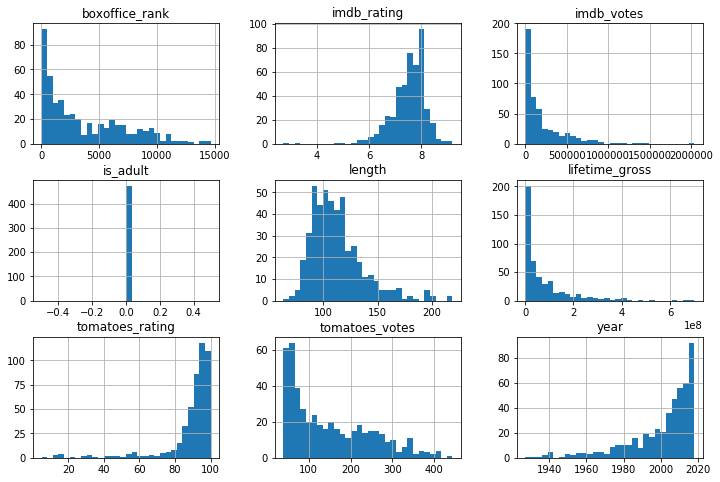

In [53]:
movies_complete.hist(figsize=(12, 8), bins=30);    # Histogram coby přibližná distribuční funkce

Nejjednodušším pohledem na dvě číselné proměnné je klasický bodový graf ([`.plot.scatter`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.scatter.html?highlight=scatter)), který jsme si už ukazovali - hodnoty dvou proměnných tvoří hodnoty souřadnic. Pomocí něj se podíváme, jaký je vztah mezi počtem hodnotitelů a průměrným hodnocením na IMDB. Očekáváme, že na špatné filmy se "nikdo nedívá", v čemž nám následující graf dává za pravdu:

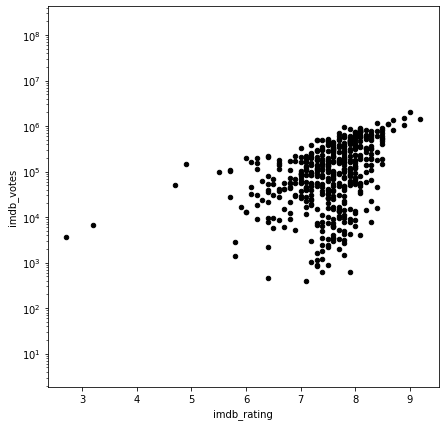

In [54]:
movies_complete.plot.scatter(
    x="imdb_rating",
    y="imdb_votes",
    c="black",
    figsize=(7, 7),
    logy=True
);

💡 Podobnou službu udělá i funkce seabornu [`scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html), jen neumí logaritmické měřítko sama o sobě.

Už při několika stovkách filmů nám ale začínají jednotlivé body splývat. Stejný graf pro všechny ohodnocené filmy (~200 000) bude vypadat už naprosto nepřehledně:

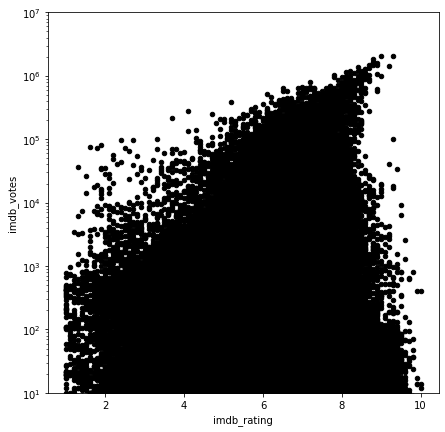

In [55]:
movies_with_rating.plot.scatter(
    x="imdb_rating",
    y="imdb_votes",
    c="black",
    figsize=(7, 7),
    logy=True,
    ylim=(10, 1e7)
);

Pro takové množství zřejmě bude vhodnější nějakým způsobem reflektovat spíš souhrnnou hustotu bodů než jednotlivé body jako takové. První možností je udělat body dostatečně "průhledné" (pomocí argumentu `alpha`) a velké (argument `s`), aby splývaly a výraznější barva odpovídala více bodům v témže okolí:

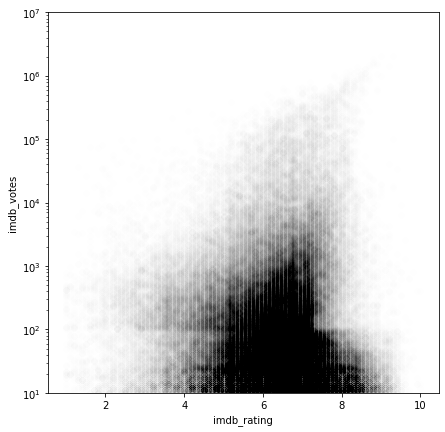

In [56]:
ax = movies_with_rating.plot.scatter(
    x="imdb_rating",
    y="imdb_votes",
    c="black",
    figsize=(7, 7),
    s=50,                # Velikost na "rozprostření"
    logy=True,
    alpha=0.002,         # > 99% průhlednost
    lw=0 ,               # bez okrajů
    ylim=(10, 1e7)
)

**Otázka (bez známé správné odpovědi):** Proč je nespojitost v hodnocení cca u sta hlasujících?

Jinou (a lepší) možností je "spočítat" dvourozměrný histogram, který místo binů "od-do" nabízí obdélníkové chlívečky ve dvou dimenzích. Poté ho lze vizualizovat pomocí *teplotní mapy* (heatmap) - každý obdélník se vybarví tím intenzivnější barvou, čím více hodnot do něj "spadlo". Pandas ani seaborn tuto možnost jednoduše nenabízejí, ale matplotlib nabízí užitečnou funkci [`hist2d`](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.hist2d.html). Všimni si, že předáváme řady jako takové, nikoliv jejich názvy!

Při kreslení rovnou nastavíme dva klíčové argumenty:

- `range`: obsahuje dvojice mezí v jendnotlivých dimenzích (nadbytek závorek je tuple tuplů).
- `cmap`: barevná paleta použitá pro vyjádření hodnot, seznam možností jde nalézt v [dokumentaci](https://matplotlib.org/examples/color/colormaps_reference.html).

**Poznámka:** Není úplně jednoduché pracovat s histogramy v logaritmické škále, a proto si vybereme jinou dvojici proměnných (hodnocení na IMDB a rotten tomatoes):

(array([[ 0.,  0.,  0.,  2.,  5.,  3.,  4.,  4.,  2.,  1.,  0.],
        [ 1.,  2.,  2.,  2.,  7.,  4.,  8.,  7.,  4.,  3.,  1.],
        [ 1.,  1.,  3.,  1.,  4.,  6., 10.,  8.,  9.,  3.,  1.],
        [ 1.,  3.,  3.,  6.,  5.,  4., 13., 15., 12.,  9.,  1.],
        [ 1.,  0.,  1.,  0.,  7.,  8.,  7., 10., 19.,  7.,  2.],
        [ 0.,  1.,  1.,  2.,  4.,  8., 12., 14., 16.,  8.,  4.],
        [ 0.,  0.,  0.,  1.,  0.,  7.,  2.,  7., 10.,  8.,  3.],
        [ 0.,  0.,  0.,  2.,  0.,  0.,  1.,  2.,  3., 11.,  4.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  6.,  1.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.]]),
 array([6.85, 7.05, 7.25, 7.45, 7.65, 7.85, 8.05, 8.25, 8.45, 8.65, 8.85,
        9.05]),
 array([ 79.5,  81.5,  83.5,  85.5,  87.5,  89.5,  91.5,  93.5,  95.5,
         97.5,  99.5, 101.5]),
 <matplotlib.collections.QuadMesh at 0x7f9b85c1b2b0>)

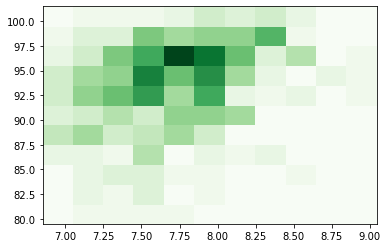

In [57]:
plt.hist2d(
    movies_complete["imdb_rating"],
    movies_complete["tomatoes_rating"],
    range=((6.85, 9.05), (79.5, 101.5)),
    bins=(11, 11),
    cmap="Greens"
)  # -> (data, hranice v první ose, hranice v druhé ose, objekt grafu)

Čím tmavší zelená, tím více filmů je v daném rozsahu.

Následující obrázek intuitivně vyjadřuje, jak body do chlívečků padají (vlevo trochu zamíchané body, vpravo spočítané obsahy chlívečků):

![Plnění 2D histogramu](static/plneni_2d_hist.png)

*Kód (velmi volitelný) k vytvoření obrázku je v bonusovém materiálu*

Biny nemusí být jenom pravoúhlé, ale pokud chceme poněkud méně diskriminovat různé směry, můžou se hodit biny šestiúhelníkové, které vykreslíš metodou [`.plot.hexbin`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.hexbin.html):

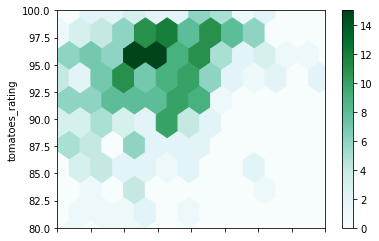

In [58]:
movies_complete.plot.hexbin(
    x="imdb_rating",
    y="tomatoes_rating",
    xlim=(7, 9),
    ylim=(80, 100),
    gridsize=40
)

Jinou možností, výpočetně náročnější, je odhadnout hustotu pravděpodobnosti výskytu filmů s danými souřadnicemi obou hodnocení. K tomu slouží tzv. **jádrový odhad hustoty** (kernel density estimate). Je to vlastně trochu sofistikovanější podoba splývání bodů, které jsme předvedli výše - kolem každého bodu se uvažuje pravěpodobnostní jádro, neboli **kernel** (typicky gaussovský), a výsledná pravděpodobnost je rovná součtu kernelů v daném místě souřadnicové soustavy.

V seabornu k tomu slouží funkce [`kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) - v jednorozměrném případě kreslí křivku, v dvourozměrném umí vykreslit buď "vrstevnice", nebo plochy různě intenzivní barvou podle spočítané hustoty pravděpodobnosti.

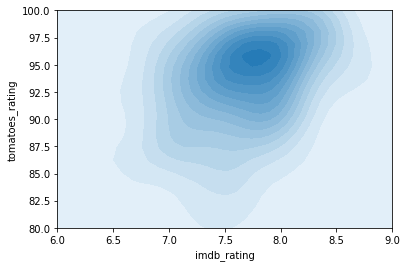

In [59]:
ax = sns.kdeplot(
    movies_complete["imdb_rating"],
    movies_complete["tomatoes_rating"],
    n_levels=15,                        # Počet úrovní intenzity
    shade=True                          # Nechceme jen "vrstevnice", ale barevnou výplň
)

# Ještě si pomocí matplotlibu upravíme rozsahy os
ax.set_xlim(6, 9)
ax.set_ylim(80, 100);

Funkce seabornu zvaná [`jointplot`](https://seaborn.pydata.org/generated/seaborn.jointplot.html) umí velice elegantně vytvořit kombinovaný graf obsahující:

* některý z výše uvedených typů grafu (jeho jméno přijde do argumentu `kind`) vztahu obou proměnných (velký čtverec uprostřed)

* rozdělení v obou proměnných nezávisle (malé histográmky nebo jádrové odhady hustoty po stranách)

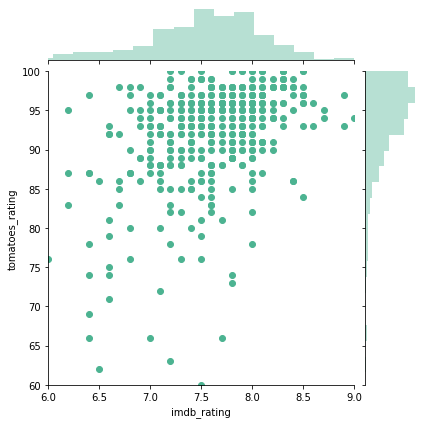

In [60]:
sns.jointplot(
    movies_complete["imdb_rating"],
    movies_complete["tomatoes_rating"],
    kind="scatter",
    color="#4CB391",
    xlim=(6, 9),
    ylim=(60, 100)
);

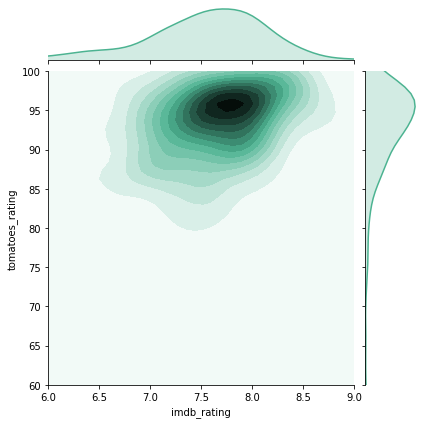

In [61]:
sns.jointplot(
    movies_complete["imdb_rating"],
    movies_complete["tomatoes_rating"],
    kind="kde",
    color="#4CB391",
    n_levels=15,
    shade=True,
    xlim=(6, 9),
    ylim=(60, 100)
);

### Korelace a kauzalita

Máme-li dvě proměnné, obvykle nás zajímá, jak spolu souvisejí. Jestli ze změny jedné můžeme usuzovat na změnu druhé a naopak. V tomto smyslu rozlišuje dva základní úrovně vztahu:

[**Korelace**](https://cs.wikipedia.org/wiki/Korelace) mezi dvěma proměnnými znamená, že pokud se jedna z nich mění, mění se nějakým způsobem i druhá, a to v míře, kterou dokážeme alespoň částečně odhadnout. Není řečeno (obvykle to ani nejde), jestli jde o vztah příčinný (jedním, nebo druhým směrem), nebo jestli jsou třeba obě proměnné jen závislé na nějakém třetím faktoru.

[**Kauzalita**](https://cs.wikipedia.org/wiki/Kauzalita) naproti tomu znamená, že jedna proměnná je opravdu závislá na druhé, a tedy že cílenou změnou první můžeme přivodit změnu druhé. 

Statistickými metodami je velice snadné prokázat korelaci, naopak je velice obtížné až nemožné ze samotných čísel vykoukat kauzalitu - to většinou vyžaduje hlubší znalost kontextu a cílené experimentování, nikoliv jen pozorování.

My si můžeme říct, jak spolu souvisí (jaká je korelace mezi nimi) hodnocení na IMDB a Rotten Tomatoes, ale těžko z čísel vyčteme, jestli se navzájem ovlivňují (aniž bychom se ptali hlasujících, na základě čeho se rozhodovali). Nejspíš selským rozumem dojdeme k tomu, že z hlediska kauzality jsou obě hodnocení nezávislá a že za případnou korelaci může spíše třetí faktor, tj. "jak se film povedl".

#### Korelační koeficient

Ve světě statistiky míru korelace obvykle vyjadřujeme pomocí **korelačního koeficientu**. To je bezrozměrné číslo od -1 do 1, přičemž 0 znamená naprostou nezávislost, 1 značí, že jakákoliv změna v jedné veličině je provázena stejně významnou změnou ve veličině druhé, -1 pak značí změnu stejně významnou, ale v opačném směru.

Existuje několik metod výpočtu korelačního koeficientu. Pandas umí v základu tři, z nich si ukážeme jen ten výchozí, Pearsonův, který je ideální pro odhalení lineárních vztahů.

Následující obrázek ukazuje typické hodnoty korelačního koeficientu pro různá rozdělení dvou proměnných:

![Ukázky korelačních koeficientů](static/korelace.png)

*Obrázek převzat z [wikipedie](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg).*

Výpočet korelačního koeficientu mezi dvěma `Series` se v pandas provede zavoláním metody [`.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.corr.html):

In [62]:
movies_complete["imdb_rating"].corr(movies_complete["tomatoes_rating"])

0.6673272196886042

Číslo 0,667 ukazuje na poměrně silný vztah - čím lepší hodnocení na jednom serveru, tím lepší hodnocení na serveru druhém.

Kompletní tabulku korelačních koeficientů mezi všemi sloupci v tabulce získáš metodou [`.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) na tabulce samotné:

In [63]:
movies_complete.corr(method="pearson")  # Jsme explicitní ohledně typu koeficientu

,is_adult,year,length,imdb_rating,imdb_votes,boxoffice_rank,lifetime_gross,tomatoes_rating,tomatoes_votes
is_adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,1.000000,-0.164026,-0.258788,-0.020599,0.024687,0.105194,-0.143181,0.583895
length,NaN,-0.164026,1.000000,0.264138,0.325280,-0.227022,0.211506,0.001890,0.141379
imdb_rating,NaN,-0.258788,0.264138,1.000000,0.465902,-0.107621,0.202497,0.667327,0.075651
imdb_votes,NaN,-0.020599,0.325280,0.465902,1.000000,-0.529907,0.649080,0.167706,0.434226
boxoffice_rank,NaN,0.024687,-0.227022,-0.107621,-0.529907,1.000000,-0.612221,0.028940,-0.432609
lifetime_gross,NaN,0.105194,0.211506,0.202497,0.649080,-0.612221,1.000000,0.077516,0.499844
tomatoes_rating,NaN,-0.143181,0.001890,0.667327,0.167706,0.028940,0.077516,1.000000,0.059786
tomatoes_votes,NaN,0.583895,0.141379,0.075651,0.434226,-0.432609,0.499844,0.059786,1.000000


Co je z tabulky vidět?

- každá proměnná plně koreluje sama se sebou (1,0)
- nelze spočítat korelační koeficient `is_adult`, protože tento sloupec obsahuje jen jednu hodnotu 
- jak jsme již zmiňovali, hodně korelují hodnocení na IMDB a na Rotten Tomatoes
- čím více hlasů na IMDB, tím obvykle lepší hodnocení (kdo by se díval na špatné filmy?), vyšší celkový zisk v kinech (kdo by hodnotil, kdyby film nikdo neviděl?)
- možná překvapí silná korelace počtu hodnocení na Rotten Tomatoes a roku premiéry (je to tím, že se filmově-kritické weby množí jako houby po dešti?)

A mnoho dalšího...

**Varování:** Velký (kladný nebo záporný) korelační koeficient téměř vždy značí nějaký (zejména lineární či aspoň monotónní) vztah mezi proměnnými. Opačně to ovšem neplatí - korelační koeficient blízký nule může zahrnovat jak případy naprosté nezávislosti, tak situace, kdy vztah mezi proměnnými je komplexnějšího charakteru, jak je vidět v dolním řádku obrázku výše.

Dovedeno do extrému, není vůbec problém nakreslit téměř libovolně vypadající obrázek alias bodový graf, který bude mít dané souhrnné statistiky (tedy naivně pohlíženo "bude stejný"). V pěkném interaktivním článku [Same Stats, Different Graphs...](https://www.autodeskresearch.com/publications/samestats) autoři ukazují pěkné animace plynulých přechodů mezi naprosto odlišně vyhlížejícími sadami, aniž by se změnila kterákoliv ze základních statistik včetně korelací.

Pokud chceě najednou zobrazit vztahy všech dvojic různých numerických proměnných, může se hodit funkce [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html), která vykresli čtvercovou mřížku s histogramy diagonále a dvourozměrnými grafy (ve výchozím nastavení bodovými) mimo diagonálu:

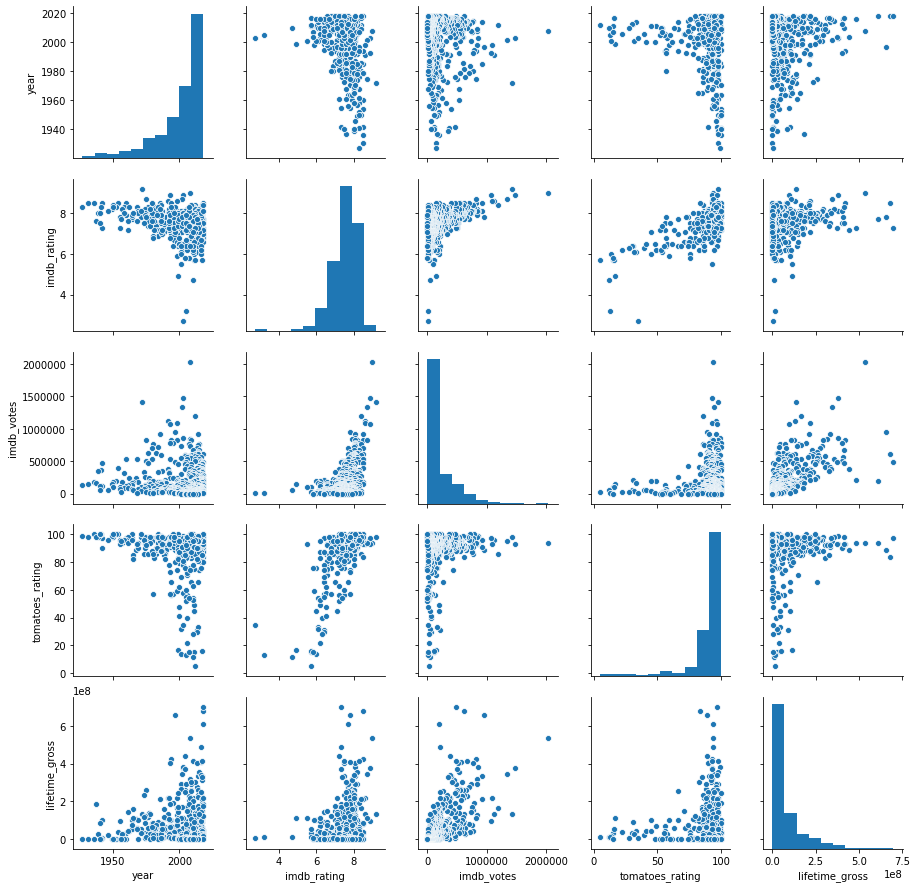

In [64]:
sns.pairplot(movies_complete[["year", "imdb_rating", "imdb_votes", "tomatoes_rating", "lifetime_gross"]])

### Dvě kategorické proměnné


Protože máme kategorických proměnných v tabulkách o filmech málo, musíme si je vyrobit. A přitom se naučíme další dva triky.

**První trik:** Kategorická proměnná z číselné

Vezmeme rok premiéry filmu a přiřadíme mu dekádu pomocí funkce [`cut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html). Tato funkce vezme nějakou číselnou `Series` a hranice binů ("chlívečků", stejně jako u histogramu) a každou hodnotu označí příslušným intervalem (jeho dolní a horní hranicí):

In [65]:
pd.cut(
    movies_with_rating["year"],
    bins=range(1890, 2021, 10)     # 1890, 1900, 1910, ..., 2020
)

tconst
tt0000009    (1890, 1900]
tt0000147    (1890, 1900]
tt0000335    (1890, 1900]
tt0000574    (1900, 1910]
tt0000615    (1900, 1910]
                 ...     
tt9910930    (2010, 2020]
tt9911774    (2010, 2020]
tt9913056    (2010, 2020]
tt9913084    (2010, 2020]
tt9914286    (2010, 2020]
Name: year, Length: 232496, dtype: category
Categories (13, interval[int64]): [(1890, 1900] < (1900, 1910] < (1910, 1920] < (1920, 1930] ... (1980, 1990] < (1990, 2000] < (2000, 2010] < (2010, 2020]]

To je přesné, ale nepříliš estetické. Takže provedeme ještě jednu úpravu - z intervalu pomocí metody `apply` uděláme hezké označení dekády (`(1980, 1990]` nahradíme řetězcem `"1980s"`).

💡 Metoda [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html) umožňuje použít libovolnou transformaci (funkci) na každý řádek v tabulce či hodnotu v `Series`. Obvykle se bez ní obejdeme a měli bychom (proto se jí tolik speciálně nevěnujeme), protože není příliš výpočetně efektivní, ale tady je nejspíš potřeba.

In [66]:
pd.cut(
    movies_with_rating["year"],
    bins=range(1890, 2021, 10)
).apply(lambda interval: str(interval.left)+"s"),

(tconst
 tt0000009    1890s
 tt0000147    1890s
 tt0000335    1890s
 tt0000574    1900s
 tt0000615    1900s
              ...  
 tt9910930    2010s
 tt9911774    2010s
 tt9913056    2010s
 tt9913084    2010s
 tt9914286    2010s
 Name: year, Length: 232496, dtype: category
 Categories (13, object): [1890s < 1900s < 1910s < 1920s ... 1980s < 1990s < 2000s < 2010s],)

💡 V pravém smyslu tedy dekáda není kategorickou, ale **ordinální** proměnnou, protože má přirozené řazení, ale nic nám nebrání s ní jako s kategorickou zacházet.

**Druhý trik:** Kategorická proměnná ze seznamu hodnot
    
Sloupec `genres` je velice užitečný, ale protože obsahuje různé kombinace hodnot, navíc oddělených čárkou v řetězci, s ním samotným toho moc nepořídíme. Potřebujeme proto skupiny žánrů rozhodit do nezávislých řádků (každý film se nám pak v tabulce opakovat tolikrát, do kolika různých žánrů patří). K tomu použijeme metody [`str.split`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html) (rozděluje řetězec na seznam podle nějakého oddělovače) a [`explode`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html) (zkopíruje řádek pro každou jednotlivou položku seznamu v nějakém sloupci):

In [67]:
(movies_with_rating["genres"]
    .str.split(",")    # řetězec -> seznam
    .explode()         # zkopíruje řádky => pro každý žánr jednu kopii
)

tconst
tt0000009        Romance
tt0000147    Documentary
tt0000147           News
tt0000147          Sport
tt0000335      Biography
                ...     
tt9911774          Drama
tt9913056    Documentary
tt9913084    Documentary
tt9914286          Drama
tt9914286         Family
Name: genres, Length: 397539, dtype: object

Toto je pravověrná kategorická proměnná. Pojďme si tedy sestavit tabulku, která obsahuje obě:

In [68]:
decades_and_genres = (
    movies_with_rating .assign(
        decade = pd.cut(
            movies_with_rating["year"],
            bins=range(1890, 2021, 10)
        ).apply(
            lambda interval: str(interval.left)+"s"
        ),
        genres = movies_with_rating["genres"].str.split(",")
    )
    .rename({"genres": "genre"}, axis="columns")
    .explode("genre")
)[["title", "genre", "decade", "imdb_rating", "imdb_votes"]]

decades_and_genres

,title,genre,decade,imdb_rating,imdb_votes
tconst,,,,,
tt0000009,Miss Jerry,Romance,1890s,5.5,77
tt0000147,The Corbett-Fitzsimmons Fight,Documentary,1890s,5.2,289
tt0000147,The Corbett-Fitzsimmons Fight,News,1890s,5.2,289
tt0000147,The Corbett-Fitzsimmons Fight,Sport,1890s,5.2,289
tt0000335,Soldiers of the Cross,Biography,1890s,6.3,39
...,...,...,...,...,...
tt9911774,Padmavyuhathile Abhimanyu,Drama,2010s,8.5,363
tt9913056,Swarm Season,Documentary,2010s,6.2,5
tt9913084,Diabolik sono io,Documentary,2010s,6.2,6


U dvou kategorických proměnných nás obvykle zajímá, jak často se vyskytuje jejich kombinace - v našem případě tedy kolik filmů daného žánru bylo natočeno v které dekádě. Toto přesně dělá funkce [`crosstab`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html):

In [69]:
decades_vs_genres = pd.crosstab(
    decades_and_genres["decade"],   # Co se použije jako řádky
    decades_and_genres["genre"],    # Co se použije jako sloupce
)

Případně nemusíme zkoumat jenom počet, může nás zajímat i jiná agregace - v tom případě musíme uvést argumenty `values` (na čem se agregace bude provádět) a `aggfunc` (jaká agregační funkce se použije). 

Zkusme tedy např. průměrné hodnocení jednotlivých žánrů v dané dekádě (že by se dokumentání filmy lepšily a horory horšily?):

In [70]:
decades_vs_genres_rating = pd.crosstab(
    index=decades_and_genres["decade"],
    columns=decades_and_genres["genre"],
    values=decades_and_genres["imdb_rating"],
    aggfunc="mean"
)

decades_vs_genres_rating[["Documentary", "Horror"]]  # Vybereme dva zajímavé sloupce

genre,Documentary,Horror
decade,,
1890s,5.933333,NaN
1900s,5.544444,2.700000
1910s,6.651282,6.085455
1920s,6.828378,6.590909
1930s,6.651695,6.145238
1940s,6.656863,6.009353
1950s,6.698214,5.617152
1960s,6.844887,5.419376
1970s,6.980501,5.309965


Pokud si chceme hodnoty z `.crosstab`, můžeme si nakreslit teplotní mapu (podobně jako dříve u dvourozměrných histogramů) pomocí funkce [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html):

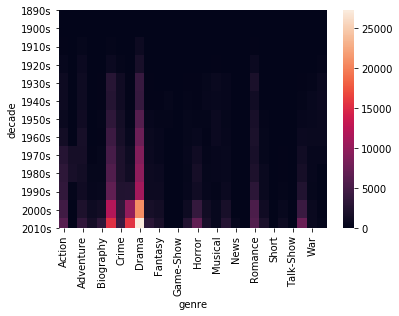

In [71]:
sns.heatmap(decades_vs_genres);

Toto jednoduché zobrazení asi není příliš přehledné, proto zkusíme přidat trochu estetiky. Většinu popsaných argumentů najdeš v dokumentaci a okomentovanou přímo v kódu, širší komentář (zejména k barevné paletě) pro "jednoduchost" vynecháme:

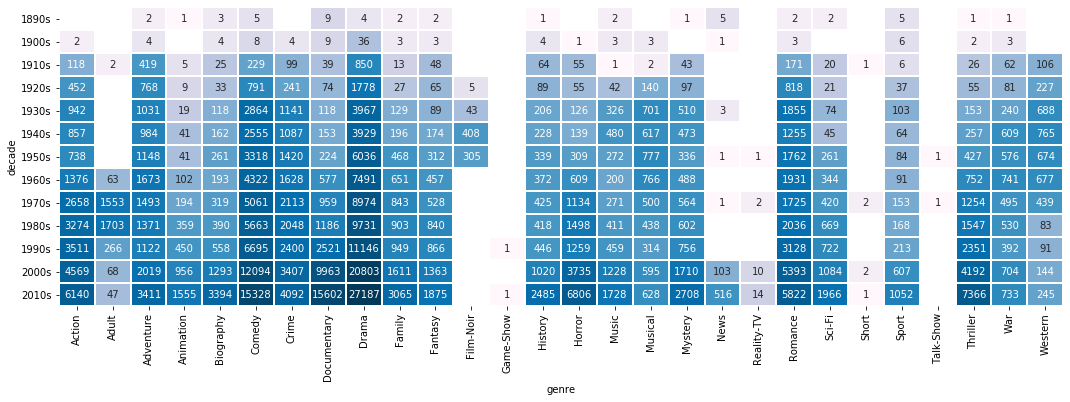

In [72]:
from matplotlib.colors import LogNorm

# Vytvoříme si škálu hodnot rovnoměrnou v logaritmickém měřítku
# Tato škála se pakkterá bude mapovat 
log_norm = LogNorm(
    vmin=1,                                # Kde škála začíná
    vmax=decades_vs_genres.max().max(),    # Kde škála končí
)

_, ax = plt.subplots(figsize=(18,5.5))   # Vytvoříme dostatečně veliký graf
sns.heatmap(
    decades_vs_genres,
    ax=ax,                  # Kreslíme do připraveného objektu `Axes`
    vmin=1,                 # Ignorujeme nulové hodnoty (nejdou logaritmovat!)
    linewidths=1,           # Oddělíme jednotlivá okénka
    annot=True,             # Chceme zobrazit hodnoty
    fmt="d",                # Zobrazíme hodnoty jako celá čísla
    norm=log_norm,          # Použijeme škálování
    cmap="PuBu",            # Vybereme si barevnou paletu
    cbar=False,             # Schováme barevný proužek vpravo, nepotřebujeme ho
);
ax.set_ylim(13, 0);         # Obcházíme oříznutí, které je asi bug seabornu

Prakticky vzato se pak tato vizualizace nachází někde na pomezí tabulky a grafu.

### Kategorická a číselná proměnná

Když se zkoumají vztahy kategorických a numerických proměnných, koukáme se vlastně na sadu numerických proměnných, vyhodnocovaných pro každou hodnotu kategorické proměnné zvlášť. V našem případě tedy pro horory zvlášť, pro dokumenty zvlášť apod. Z výpočetního hlediska je toto téma pro shlukování a operaci `groupby`, kterým se detailně věnuje příští hodina. Nyní si jen ukážeme některé pěkné vizualizace.

Krabicový graf si jistě pamatuješ z minula, pomocí seabornu ho vytvoříš zavoláním funkce [`boxplot`](https://seaborn.pydata.org/generated/seaborn.boxplot.html) - jen se nekreslí krabičky pro různé proměnné, ale pro tutéž číselnou proměnnou, nýbrž v závislosti na proměnné kategorické:

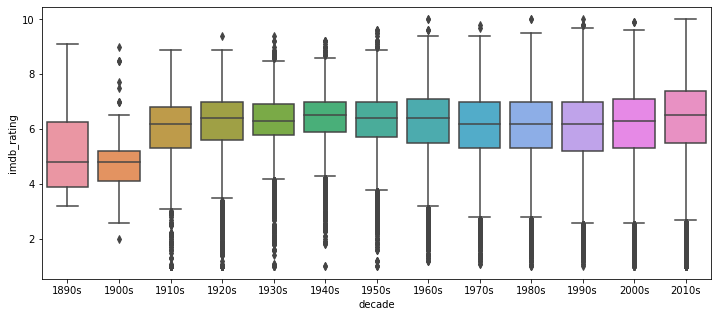

In [73]:
_, ax = plt.subplots(figsize=(12, 5))     # boxplot neumí specifikovat velikost grafu
sns.boxplot(data=decades_and_genres, 
    x="decade",
    y="imdb_rating",
    ax=ax)       # kam se bude kreslit

Vedle toho "strip plot" (funkce [`stripplot`](https://seaborn.pydata.org/generated/seaborn.stripplot.html)) znázorňuje každou hodnotu tečkou, vysázenou ve sloupci nad příslušnou kategorií (ve správné výšce, nicméně přesné horizontální umístění nenese žádnou informaci):

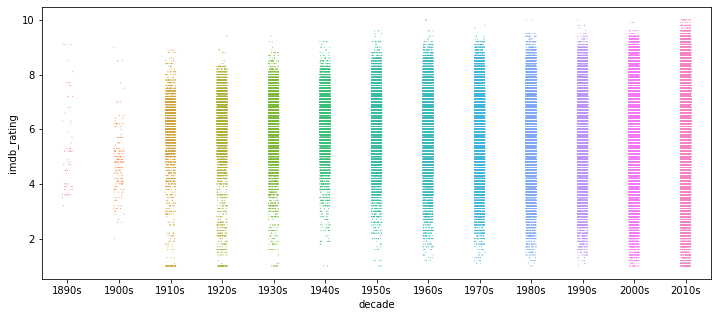

In [74]:
_, ax = plt.subplots(figsize=(12, 5)) # stripplot neumí specifikovat velikost grafu
sns.stripplot(
    data=decades_and_genres, 
    x="decade",
    y="imdb_rating",
    s=1,
    ax=ax); 

Velice podobnou roli jako krabicový graf hraje houslový ~plot~ graf, který místo čtverců nabízí miniaturní křivku hustoty pravděpodobnosti (resp. jádrový odhad). Vykreslíš ho funkcí [`violinplot`](https://seaborn.pydata.org/generated/seaborn.violinplot.html?):

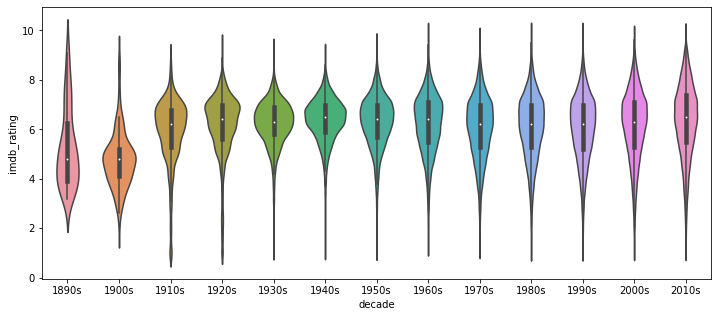

In [75]:
_, ax = plt.subplots(figsize=(12, 5))  # violinplot neumí specifikovat velikost grafu
sns.violinplot(
    data=decades_and_genres,
    x="decade",
    y="imdb_rating",
    ax=ax)  

## Vztahy mezi více proměnnými

Pokud si tyto materiály nečteš na holografickém displeji, jsi při zobrazování dat omezen/a na dva rozměry. Můžeš si prohlížet dvourozměrné tabulky, kreslit dvourozměrné grafy. Interaktivní knihovny pro vizualizaci dat ti pomocí posuvníků umožní prohlížet si různé jednorozměrné nebo dvourozměrné řezy vícerozměrných vztahů.

Matplotlib i plotly umějí vykreslovat 3D grafy, tak se tím můžeš inspirovat, ale není to moc praktické.

### 3D grafy (nepovinné až zbytečné)

Pokud chceš v matplotlibu kreslit trojrozměrné grafy, musíš si síť souřadnic vytvořit specifickým způsobem.

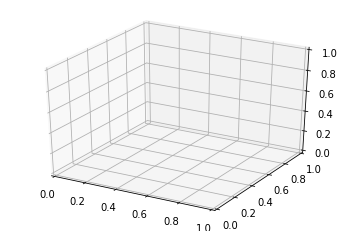

In [76]:
from mpl_toolkits.mplot3d import Axes3D     # Import, bez kterého nebude následující fungovat

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 

Potom už se zbylá volání budou chovat podobně jako ve dvou rozměrech:

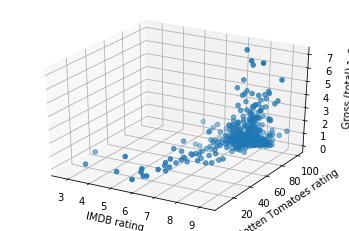

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    movies_complete["imdb_rating"],
    movies_complete["tomatoes_rating"],
    movies_complete["lifetime_gross"])
ax.set_xlabel("IMDB rating")
ax.set_ylabel("Rotten Tomatoes rating")
ax.set_zlabel("Gross (total)");

Graf je to poněkud statický a třetí rozměr nám uniká (a ani 3D brýle nepomohou). 

Pokud kreslíš grafy mimo jupyter notebook a máš například nainstalovaný framework Qt, můžeš si grafy z matplotlibu
prohlížet i interaktivně, což v tomto případě je velice užitečné.

Naproti tomu uvnitř notebooku v notebooku je výrazně efektivnější použít `plotly` (resp. `plotly.express`):

In [ ]:
# Toto nemusí fungovat všem, můj prohlížeč si stěžuje na chybějící WebGL
import plotly.express as px
df = px.data.election()
fig = px.scatter_3d(movies_complete, x="imdb_rating", y="tomatoes_rating", z="lifetime_gross", hover_name="title")
fig.show()

## Bonusový materiál

Obrázek ilustrující plnění 2D histogramu:

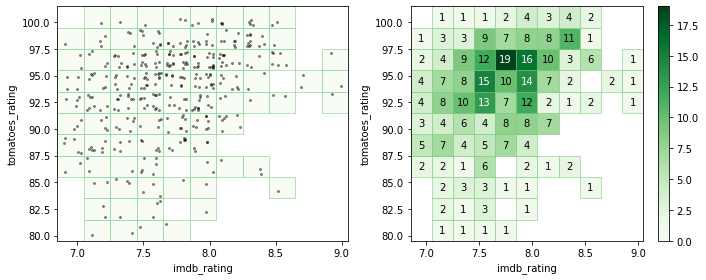

In [79]:
import numpy as np
import physt

np.random.seed(42)

limits=((6.85, 9.05), (79.5, 101.5))
bins=(11, 11)

# Ve phystu vytvoříme objekt 2D histogramu
h2 = physt.h2(
    movies_complete["imdb_rating"],
    movies_complete["tomatoes_rating"],
    bins=bins,
    range=limits,
)

# Chceme ne jeden, ale dva grafy vedle sebe!!!
fig, ax = plt.subplots(1, 2, figsize=(10,4))

##### levý graf

# Vykreslíme si histogram, ale schováme ho
h2.plot(
    cmap="Greens",            # Paleta, kterou použijeme v pravém grafu
    cmap_min=0,
    cmap_max=1e9,             # Zajistíme si, že všechy biny budou mít první barvu palety
    show_zero=False,          # Nenakreslí se nám prázdné biny
    ax=ax[0],                 # Nakreslíme do levého podgrafu
    show_colorbar=False,      # Nepotřebujeme legendu k paletě
    zorder=-1,                # Schováme za následující scatterplot
    #alpha=0,
)

# Scatterplot překreslený přes "histogram" s body mírně rozházenými, aby se daly spočítat
ax[0].scatter(
    movies_complete["imdb_rating"] + np.random.uniform(-.03, .03, len(movies_complete["imdb_rating"])),
    movies_complete["tomatoes_rating"]+ np.random.uniform(-.3, .3, len(movies_complete["imdb_rating"])),
    s=4,
    color="black",
    alpha=0.4,
)
ax[0].set_xticks([7.0, 7.5, 8.0, 8.5, 9.0])

##### Pravý graf ukazuje, kolik bodů spadlo do kterého obdélníku

# Tady už použijeme vykreslování histogramů

h2.plot(
    show_values=True,         # Chceme v binech zobrazit čísla
    cmap="Greens", 
    show_zero=False,
    ax=ax[1],                 # Kreslíme do pravéoho podgrafu
    show_colorbar=True        # Chceme ukázat legendu k paletě
)

# Uložíme obrázek s dostatečným rozlišením

fig.savefig("static/plneni_2d_hist.png", dpi=300)